In [1]:
from predictor_new import NMRPredictor

In [9]:
predObject = NMRPredictor("checkpoints/best_model.meta", "checkpoints/best_model_new.00000000.model", USE_CUDA = True)

In [10]:
predObject.predict("C/C=C/C(C)=C")

[16.06142234802246,
 121.70999145507812,
 134.16610717773438,
 156.76893615722656,
 15.64548110961914,
 77.79364776611328]

In [11]:
import numpy as np

In [12]:
from scipy.stats import wasserstein_distance
target_nmr = np.array([18.3, 18.8, 114.5, 125.1, 135.5, 142.2])
calc_nmr = np.array(predObject.predict("C/C=C/C(C)=C"))
target_nmr/= 220
calc_nmr /= 220
reward = 1 - wasserstein_distance(calc_nmr,target_nmr)
print(reward)
print(2*(reward-0.5))

0.9534906921964703
0.9069813843929406


In [1]:
from predictor import NMRPredictor
import pickle

In [2]:
from graph_conv_many_nuc_pred import Model

In [63]:
Pred = Model("checkpoints/best_model_new.meta", "checkpoints/best_model_new.00000000.model", USE_CUDA = True)

In [28]:
with open("graph_conv_many_nuc_pipeline.datasets/graph_conv_many_nuc_pipeline.data.13C.nmrshiftdb_hconfspcl_nmrshiftdb.aromatic.64.0.mol_dict.pickle", "rb") as inFile:
    dat = pickle.load(inFile)

In [29]:
from rdkit.Chem import AllChem
from rdkit import Chem

In [30]:
df =  dat["test_df"]

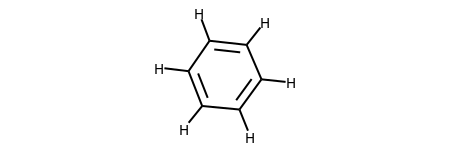

In [66]:
mol

In [64]:
mol = Chem.MolFromSmiles("C1=CC=CC=C1")
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
val = [{0: 0,2:0}]
mol.GetNumAtoms()

12

In [65]:
Pred.pred([mol],[val])

100%|██████████| 1/1 [00:00<00:00, 37.30it/s]


,i_batch,atom_idx,m_pos,nuc_i,nuc,std_out,value,est,std
0,0,0,0,0,13C,True,0.0,119.436104,0.802857
1,0,2,0,0,13C,True,0.0,119.436104,0.802857


In [34]:
dat["test_df"]

,molecule_id,rdmol,spectra_ids,value
1,4002,<rdkit.Chem.rdchem.Mol object at 0x150d3a207bf0>,[2],"[{9: 50.9, 3: 35.8, 7: 146.7, 14: 22.9, 11: 39..."
5,4008,<rdkit.Chem.rdchem.Mol object at 0x150d3a207c30>,[8],"[{2: 23.9, 3: 52.0, 1: 21.2, 8: 51.1, 0: 12.9,..."
9,4012,<rdkit.Chem.rdchem.Mol object at 0x150d3a207c70>,[12],"[{12: 104.9, 9: 136.2, 27: 128.1, 19: 127.0, 2..."
14,4019,<rdkit.Chem.rdchem.Mol object at 0x150d3a207cb0>,[20],"[{11: 170.74, 17: 22.09, 4: 54.44, 13: 42.21, ..."
24,4030,<rdkit.Chem.rdchem.Mol object at 0x150d3a207cf0>,[34],"[{6: 39.41, 7: 44.34, 3: 23.04, 2: 116.1, 11: ..."
...,...,...,...,...
26851,44631,<rdkit.Chem.rdchem.Mol object at 0x150d3a140eb0>,[49439],"[{1: 122.7, 10: 131.5, 9: 129.0, 8: 140.1, 3: ..."
26871,44652,<rdkit.Chem.rdchem.Mol object at 0x150d3a140ef0>,[49461],"[{10: 132.2, 9: 130.3, 0: 128.2, 1: 132.2, 14:..."
26876,44657,<rdkit.Chem.rdchem.Mol object at 0x150d3a140f30>,[49466],"[{7: 128.4, 10: 132.1, 3: 74.6, 8: 129.4, 5: 1..."
26890,44671,<rdkit.Chem.rdchem.Mol object at 0x150d3a140f70>,[49480],"[{3: 120.7, 14: 65.4, 6: 130.3, 1: 142.5, 11: ..."


In [35]:
vals = dat["test_df"].value.tolist()
mols = dat["test_df"].rdmol.tolist()

In [2]:
from rdkit import Chem

In [12]:
import numpy as np
import torch
import pandas as pd
import atom_features
import molecule_features
from rdkit import Chem
from rdkit.Chem import AllChem
import nets
import torch

In [39]:
MAX_N = 64
default_atomicno = [1, 6, 7, 8, 9, 15, 16, 17]
default_feat_vect_args = dict(feat_atomicno_onehot=default_atomicno, 
                              feat_pos=False, feat_atomicno=True,
                              feat_valence=True, aromatic=True, hybridization=True, 
                              partial_charge=False, formal_charge=True,  # WE SHOULD REALLY USE THIS 
                              r_covalent=False,
                              total_valence_onehot=True, 
                              
                              r_vanderwals=False, default_valence=True, rings=True)


default_feat_mat_args = dict(feat_distances = False, 
                             feat_r_pow = None)

default_split_weights = [1, 1.5, 2, 3]

default_adj_args = dict(edge_weighted=False, 
                        norm_adj=True, add_identity=True, 
                        split_weights=default_split_weights)

net_params =  {
        "init_noise": 0.01,
        "resnet": True,
        "int_d": 2048,
        "layer_n": 10,
        "GS": 4,
        "agg_func": "goodmax",
        "force_lin_init": True,
        "g_feature_n": 37,
        "resnet_out": True,
        "out_std": True,
        "graph_dropout": 0.0,
        "resnet_d": 128,
        "OUT_DIM": 1
    }

In [45]:
def featuresFromMol(mol):
    #AllChem.EmbedMolecule(mol)
    conf_idx = np.random.randint(mol.GetNumConformers())        
    f_vect = atom_features.feat_tensor_atom(mol, conf_idx=conf_idx, **default_feat_vect_args)

    DATA_N = f_vect.shape[0]

    vect_feat = np.zeros((MAX_N, f_vect.shape[1]), dtype=np.float32)
    vect_feat[:DATA_N] = f_vect
    

    adj_nopad = molecule_features.feat_mol_adj(mol, **default_adj_args)
    adj = torch.zeros((adj_nopad.shape[0], MAX_N, MAX_N))
    adj[:, :adj_nopad.shape[1], :adj_nopad.shape[2]] = adj_nopad

    return  (adj,torch.tensor([vect_feat]))

In [43]:
model = nets.GraphVertModel(**net_params)

In [44]:
model.load_state_dict(torch.load("checkpoints/best_model.00000000.state"))

<All keys matched successfully>

In [49]:
ha = [atom.GetAtomicNum()==6 for atom in mols[4].GetAtoms()]

In [50]:
ha

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [49]:
ha = ha + [False] * (64-mol.GetNumAtoms())

In [46]:
shifts = model(featuresFromMol(mols[4]))["mu"].squeeze()

In [47]:
shifts

tensor([34.5063, 25.3172, 34.9550, 25.0581, 33.1610, 31.2350, 26.7636, 31.6524,
        16.6137, 21.1425, 20.6008, 24.4193, 19.0497, 14.1671, 14.1671, 23.7372,
        32.7956, 14.7037, 14.7037, 14.7037, 18.9740, 18.9740, 20.0306, 20.3588,
         9.2720,  9.2720,  9.2720, 12.4203, 12.4203, 12.3694, 12.3694, 15.9751,
        13.7275,  8.3655,  8.3655,  8.3655,  8.3655,  8.3655,  8.3655,  0.2201,
         0.2201,  0.2201,  0.2201,  0.2201,  0.2201,  0.2201,  0.2201,  0.2201,
         0.2201,  0.2201,  0.2201,  0.2201,  0.2201,  0.2201,  0.2201,  0.2201,
         0.2201,  0.2201,  0.2201,  0.2201,  0.2201,  0.2201,  0.2201,  0.2201],
       grad_fn=<SqueezeBackward0>)

In [51]:
shifts[ha]

tensor([73.0436, 76.2304, 66.0928, 58.2910, 44.8345], grad_fn=<IndexBackward>)

In [18]:
class NMRPredictor:
    def __init__(self, modelState = "checkpoints/best_model_new.00000000.state"):
        self.MAX_N = 64
        self.default_atomicno = [1, 6, 7, 8, 9, 15, 16, 17]
        self.default_feat_vect_args = dict(feat_atomicno_onehot=self.default_atomicno, 
                              feat_pos=False, feat_atomicno=True,
                              feat_valence=True, aromatic=True, hybridization=True, 
                              partial_charge=False, formal_charge=True,  # WE SHOULD REALLY USE THIS 
                              r_covalent=False,
                              total_valence_onehot=True, 
                              
                              r_vanderwals=False, default_valence=True, rings=True)


        self.default_feat_mat_args = dict(feat_distances = False, 
                             feat_r_pow = None)

        self.default_split_weights = [1, 1.5, 2, 3]

        self.default_adj_args = dict(edge_weighted=False, 
                        norm_adj=True, add_identity=True, 
                        split_weights=self.default_split_weights)

        self.net_params =  {
                "init_noise": 0.01,
                "resnet": True,
                "int_d": 2048,
                "layer_n": 10,
                "GS": 4,
                "agg_func": "goodmax",
                "force_lin_init": True,
                "g_feature_n": 37,
                "resnet_out": True,
                "out_std": True,
                "graph_dropout": 0.0,
                "resnet_d": 128,
                "OUT_DIM": 1
            }
        
        self.model = nets.GraphVertModel(**self.net_params)
        self.model.load_state_dict(torch.load(modelState))
        
    def featuresFromMol(self,mol):
        AllChem.EmbedMolecule(mol)
        conf_idx = np.random.randint(mol.GetNumConformers())        
        f_vect = atom_features.feat_tensor_atom(mol, conf_idx=conf_idx, **self.default_feat_vect_args)

        DATA_N = f_vect.shape[0]

        vect_feat = np.zeros((MAX_N, f_vect.shape[1]), dtype=np.float32)
        vect_feat[:DATA_N] = f_vect


        adj_nopad = molecule_features.feat_mol_adj(mol, **self.default_adj_args)
        adj = torch.zeros((adj_nopad.shape[0], MAX_N, MAX_N))
        adj[:, :adj_nopad.shape[1], :adj_nopad.shape[2]] = adj_nopad

        return  (adj,torch.tensor([vect_feat]))
        
    def predict(self,mol):
        shifts = self.model(self.featuresFromMol(mol))["mu"].squeeze()
        mask = [atom.GetAtomicNum()==6 for atom in mol.GetAtoms()]
        mask = mask + [False] * (self.MAX_N - mol.GetNumAtoms())
        return np.array(shifts[mask].detach())

In [19]:
pred = NMRPredictor()

In [20]:
pred.predict(Chem.MolFromSmiles("CCCO"))

NameError: name 'MAX_N' is not defined

In [21]:
from predictor import NMRPredictor

In [25]:
pred = NMRPredictor("checkpoints/best_model.00000000.state")

In [26]:
pred.predict(Chem.MolFromSmiles("C1=CC=CC=C1"))

array([65.15548, 65.15548, 65.15548, 65.15548, 65.15548, 65.15548],
      dtype=float32)